In [10]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from matplotlib import patches

from scipy.stats import shapiro, rankdata, friedmanchisquare, ttest_rel, wilcoxon
from statsmodels.stats.anova import AnovaRM
from scikit_posthocs import posthoc_ttest, posthoc_wilcoxon, posthoc_tukey_hsd, posthoc_tukey

import numpy as np
import scipy
import config as c

In [11]:
clicks_df = pd.DataFrame()
latency_conditions = [-40, -20, 0, 20, 40]
balanced_latin_square = [[0,1,4,3,2],
                        [4,2,0,3,1],
                        [3,2,1,4,0],
                        [1,0,3,4,2],
                        [4,0,2,1,3],
                        [2,3,4,1,0],
                        [1,3,0,2,4],
                        [0,4,1,2,3],
                        [2,4,3,0,1],
                        [3,1,2,0,4]]
for id in range(c.NUM_PARTICIPANTS):
    for trial in range(c.NUM_TRIALS):
        clicks_raw = pd.read_csv(
            c.FOLDER_PATH
            + str(id + 1)
            + f"/clicks_participant_{id + 1}_trial_{trial}.csv"
        )
        clicks_raw["level_of_latency"] = latency_conditions[balanced_latin_square[id][trial]]
        clicks_df = pd.concat([clicks_df, clicks_raw])
    
clicks_df.head()

,id,timestamp_ms,participant_id,trial,level_of_latency,target_number,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,0,1710166191603,1,0,-40,0,30,450,959,103,957,107,1,1.787344
1,1,1710166193111,1,0,-40,1,30,450,1113,975,1117,968,1,1.508388
2,2,1710166194311,1,0,-40,2,30,450,670,208,672,211,1,1.199971
3,3,1710166196228,1,0,-40,3,30,450,1349,778,1353,787,1,1.916836
4,4,1710166197495,1,0,-40,4,30,450,516,474,519,467,1,1.267135


In [12]:
# drop irrelevant columns
clicks_df = clicks_df.drop(
    ["timestamp_ms", "target_number"], axis=1
)
# drop rows of first click in round (no fitts law task)
clicks_df = clicks_df.drop(clicks_df.loc[clicks_df["id"] % 9 == 0].index, axis=0)
clicks_df.reset_index(inplace=True, drop=True)
clicks_df.head()

,id,participant_id,trial,level_of_latency,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,1,1,0,-40,30,450,1113,975,1117,968,1,1.508388
1,2,1,0,-40,30,450,670,208,672,211,1,1.199971
2,3,1,0,-40,30,450,1349,778,1353,787,1,1.916836
3,4,1,0,-40,30,450,516,474,519,467,1,1.267135
4,5,1,0,-40,30,450,1403,474,1409,482,1,1.045496


In [13]:
# calculation of id
clicks_df["ID"] = np.log2(clicks_df["target_amplitude"] / clicks_df["target_width"] + 1)

In [14]:
# calculation of effective id
num_ids = len(clicks_df["ID"].unique())

clicks_df["distance_from_target"] = np.sqrt(
    (clicks_df["target_x"] - clicks_df["cursor_x"])**2 +
    (clicks_df["target_y"] - clicks_df["cursor_y"])**2
)

effective_id_df = pd.DataFrame({"ID": clicks_df["ID"].unique(), 
                                "sigma": np.zeros(num_ids),
                                "amplitude": np.zeros(num_ids),
                                "width": np.zeros(num_ids)})
for _, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            row["amplitude"] = entry["target_amplitude"]
            row["width"] = entry["target_width"]
            row["sigma"] += entry["distance_from_target"]

effective_id_df["sigma"] /= len(clicks_df)/9
effective_id_df["We"] = 4.133 * effective_id_df["sigma"]
effective_id_df["IDe"] = np.log2(
    effective_id_df["amplitude"] / effective_id_df["We"] + 1
)
effective_id_df.sort_values(by=["ID"])

,ID,sigma,amplitude,width,We,IDe
5,1.000000,32.198907,200.0,200.0,133.078082,1.323587
3,1.392317,44.917568,325.0,200.0,185.644308,1.459778
8,1.415037,26.273462,200.0,120.0,108.588218,1.506815
6,1.700440,45.467754,450.0,200.0,187.918226,1.763267
2,1.890771,31.662447,325.0,120.0,130.860892,1.800560
7,2.247928,28.532752,450.0,120.0,117.925862,2.267822
4,2.938599,9.226566,200.0,30.0,38.133397,2.642643
1,3.564785,9.324391,325.0,30.0,38.537707,3.237762
0,4.000000,10.124243,450.0,30.0,41.843497,3.555124


In [23]:
# calculation of throughput
throughput_df = pd.DataFrame({"IDe": np.zeros(clicks_df.shape[0]),
                              "completion_time": clicks_df["completion_time"],
                              "error_rate": 1 - clicks_df["success"]})

for index, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            throughput_df.loc[index,"IDe"] = row["IDe"]

throughput_df["throughput"] = throughput_df["IDe"] / throughput_df["completion_time"]
throughput_df["level_of_latency"] = clicks_df["level_of_latency"]
throughput_df["participant_id"] = clicks_df["participant_id"]
throughput_df

,IDe,completion_time,error_rate,throughput,level_of_latency,participant_id
0,3.555124,1.508388,0,2.356903,-40,1
1,3.555124,1.199971,0,2.962675,-40,1
2,3.555124,1.916836,0,1.854683,-40,1
3,3.555124,1.267135,0,2.805639,-40,1
4,3.555124,1.045496,0,3.400419,-40,1
...,...,...,...,...,...,...
8635,2.642643,0.821035,0,3.218673,-40,6
8636,2.642643,0.883963,1,2.989540,-40,6
8637,2.642643,0.932972,0,2.832500,-40,6
8638,2.642643,1.191457,0,2.217993,-40,6


# Inferential Analysis
- one-way repeated-measures ANOVA (+correction??) for latency throughput
- two-way repeated-measures ANOVA for latency, id -> movement time
- two-way repeated-measures ANOVA for latency, id -> error rate
- one-way repeated-measures ANOVA for latency -> nasa tlx

Test for normal distribution for dependent variable throughput:
40ms latency: ShapiroResult(statistic=0.9319883192501923, pvalue=2.362957606939378e-27)
20ms latency: ShapiroResult(statistic=0.9678265835749149, pvalue=3.433398941587598e-19)
0ms latency: ShapiroResult(statistic=0.9359621297989199, pvalue=1.2218263622287761e-26)
-20ms latency: ShapiroResult(statistic=0.9957345408248092, pvalue=8.33128350218351e-05)
-40ms latency: ShapiroResult(statistic=0.9845092966611406, pvalue=1.0488143328934628e-12)


<Axes: xlabel='throughput', ylabel='Density'>

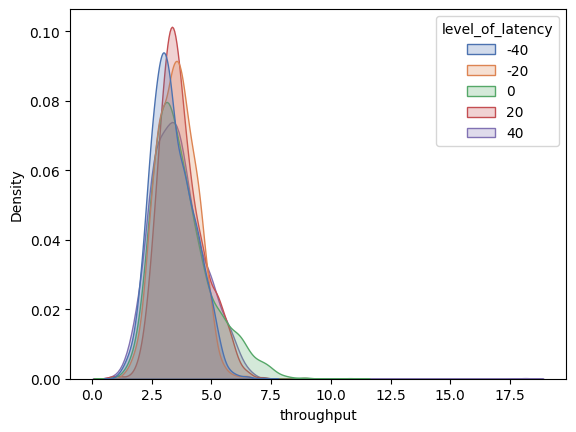

In [17]:
# check if normal distribution (voraussetzung für anova (sonst nicht-parametrischer test))
dv = 'throughput'

normal_40   = shapiro(throughput_df[throughput_df['level_of_latency'] == 40][dv])
normal_20  = shapiro(throughput_df[throughput_df['level_of_latency'] == 20][dv])
normal_0  = shapiro(throughput_df[throughput_df['level_of_latency'] == 0][dv])
normal_neg20  = shapiro(throughput_df[throughput_df['level_of_latency'] == -20][dv])
normal_neg40  = shapiro(throughput_df[throughput_df['level_of_latency'] == -40][dv])

print(f'Test for normal distribution for dependent variable {dv}:')
print(f'40ms latency: {normal_40}')
print(f'20ms latency: {normal_20}')
print(f'0ms latency: {normal_0}')
print(f'-20ms latency: {normal_neg20}')
print(f'-40ms latency: {normal_neg40}')

sns.kdeplot(data=throughput_df, x=dv, hue='level_of_latency', fill=True, palette='deep')
# alle normalverteilt

In [27]:
result = AnovaRM(data=throughput_df, depvar='throughput', 
              subject="participant_id", within=['level_of_latency'], aggregate_func='mean').fit()
result.anova_table
# kein haupteffekt

,F Value,Num DF,Den DF,Pr > F
level_of_latency,1.131335,4.0,20.0,0.370048


Test for normal distribution for dependent variable completion_time:
40ms latency: ShapiroResult(statistic=0.9334857890307522, pvalue=4.350042737891982e-27)
20ms latency: ShapiroResult(statistic=0.9224409594414302, pvalue=6.051617297616355e-29)
0ms latency: ShapiroResult(statistic=0.9410336986358159, pvalue=1.1186130768980787e-25)
-20ms latency: ShapiroResult(statistic=0.9184484568461613, pvalue=1.4491756346910183e-29)
-40ms latency: ShapiroResult(statistic=0.9355412393578214, pvalue=1.0229411616823555e-26)


<Axes: xlabel='completion_time', ylabel='Density'>

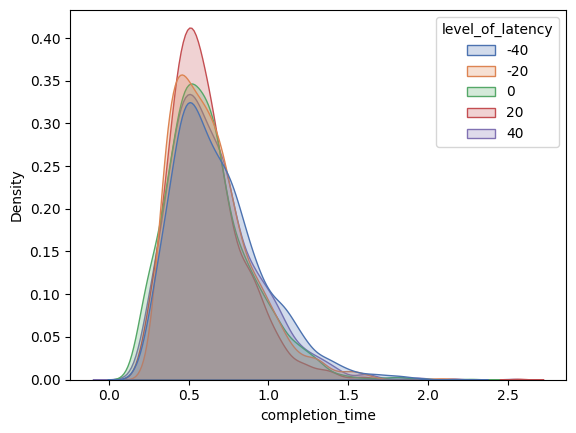

In [30]:
# check if normal distribution (voraussetzung für anova (sonst nicht-parametrischer test))
dv = 'completion_time'

normal_40   = shapiro(throughput_df[throughput_df['level_of_latency'] == 40][dv])
normal_20  = shapiro(throughput_df[throughput_df['level_of_latency'] == 20][dv])
normal_0  = shapiro(throughput_df[throughput_df['level_of_latency'] == 0][dv])
normal_neg20  = shapiro(throughput_df[throughput_df['level_of_latency'] == -20][dv])
normal_neg40  = shapiro(throughput_df[throughput_df['level_of_latency'] == -40][dv])

print(f'Test for normal distribution for dependent variable {dv}:')
print(f'40ms latency: {normal_40}')
print(f'20ms latency: {normal_20}')
print(f'0ms latency: {normal_0}')
print(f'-20ms latency: {normal_neg20}')
print(f'-40ms latency: {normal_neg40}')

sns.kdeplot(data=throughput_df, x=dv, hue='level_of_latency', fill=True, palette='deep')
# alle normalverteilt

In [28]:
result = AnovaRM(data=throughput_df, depvar='completion_time', 
              subject='participant_id', within=['level_of_latency', 'IDe'], aggregate_func='mean').fit()
result.anova_table
# haupteffekt ide und interaktionseffekt 

,F Value,Num DF,Den DF,Pr > F
level_of_latency,1.768978,4.0,20.0,1.747352e-01
IDe,141.829953,8.0,40.0,7.053003e-27
level_of_latency:IDe,1.928562,32.0,160.0,4.358866e-03


Test for normal distribution for dependent variable error_rate:
40ms latency: ShapiroResult(statistic=0.2504747012050059, pvalue=5.973811656931683e-64)
20ms latency: ShapiroResult(statistic=0.22652781622745866, pvalue=1.551811832118971e-64)
0ms latency: ShapiroResult(statistic=0.24739069524065194, pvalue=5.011568017119195e-64)
-20ms latency: ShapiroResult(statistic=0.22486044428564655, pvalue=1.4146703519854185e-64)
-40ms latency: ShapiroResult(statistic=0.2933098014119465, pvalue=7.316422469005236e-63)


<Axes: xlabel='error_rate', ylabel='Density'>

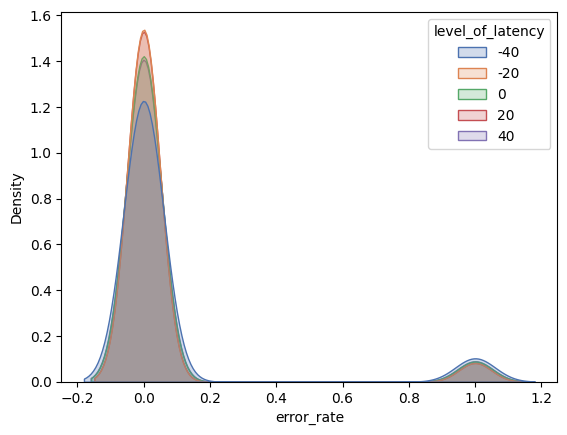

In [31]:
# check if normal distribution (voraussetzung für anova (sonst nicht-parametrischer test))
dv = 'error_rate'

normal_40   = shapiro(throughput_df[throughput_df['level_of_latency'] == 40][dv])
normal_20  = shapiro(throughput_df[throughput_df['level_of_latency'] == 20][dv])
normal_0  = shapiro(throughput_df[throughput_df['level_of_latency'] == 0][dv])
normal_neg20  = shapiro(throughput_df[throughput_df['level_of_latency'] == -20][dv])
normal_neg40  = shapiro(throughput_df[throughput_df['level_of_latency'] == -40][dv])

print(f'Test for normal distribution for dependent variable {dv}:')
print(f'40ms latency: {normal_40}')
print(f'20ms latency: {normal_20}')
print(f'0ms latency: {normal_0}')
print(f'-20ms latency: {normal_neg20}')
print(f'-40ms latency: {normal_neg40}')

sns.kdeplot(data=throughput_df, x=dv, hue='level_of_latency', fill=True, palette='deep')
# alle normalverteilt

In [32]:
result = AnovaRM(data=throughput_df, depvar='error_rate', 
              subject='participant_id', within=['level_of_latency', 'IDe'], aggregate_func='mean').fit()
result.anova_table
# nur haupteffekt von ide

,F Value,Num DF,Den DF,Pr > F
level_of_latency,1.564706,4.0,20.0,0.222288
IDe,6.302576,8.0,40.0,0.000028
level_of_latency:IDe,1.132710,32.0,160.0,0.301290
